In [47]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.stats import wasserstein_distance, kstest, pearsonr

hep.style.use(hep.style.ROOT)

In [80]:
#defining the various metrics to be investigated

#returns pearson correlation matrix for a 2D array
def pearson_matrix(a):
    off_diag = pearsonr(a[:,0], a[:,1])[0]
    return np.array([[1, off_diag], [off_diag, 1]])

def F_distance(a1, a2):
    M = pearson_matrix(a1) - pearson_matrix(a2)
    return np.linalg.norm(M, ord="fro")

#max/min of both arrays determines the range of the histogram
def B_distance(a1, a2):
    if len(a1) != len(a2): raise Exception("array dimensions don't match.")
    xmin, ymin = np.min(np.append(a1[:,0], a2[:,0])), np.min(np.append(a1[:,1], a2[:,1]))
    xmax, ymax = np.max(np.append(a1[:,0], a2[:,0])), np.max(np.append(a1[:,1], a2[:,1]))

    a1_distr = np.histogram2d(a1[:,0], a1[:,1], range=[[xmin, xmax], [ymin, ymax]], bins=int(np.sqrt(len(a1)*0.1)))[0] / len(a1)
    a2_distr = np.histogram2d(a2[:,0], a2[:,1], range=[[xmin, xmax], [ymin, ymax]], bins=int(np.sqrt(len(a2)*0.1)))[0] / len(a2)
    
    b_coeff = np.sum(np.sqrt(a1_distr*a2_distr))
    return -np.log(b_coeff)

def KS_distance(a1, a2):
    x_dist, y_dist = kstest(a1[:,0], a2[:,0])[0], kstest(a1[:,1], a2[:,1])[0]
    return (x_dist + y_dist)*0.5

def WS_distance(a1, a2):
    x_dist, y_dist = wasserstein_distance(a1[:,0], a2[:,0]), wasserstein_distance(a1[:,1], a2[:,1])
    return (x_dist + y_dist)*0.5
    

In [36]:
#generate 2d gaussian distribution. Skew goes from -1 to 1.
def generate_gaussian(pos=[0,0], n=1000, skew=0):
    return np.random.multivariate_normal(pos, [[1, skew], [skew, 1]], n)

0.0024899999999999922


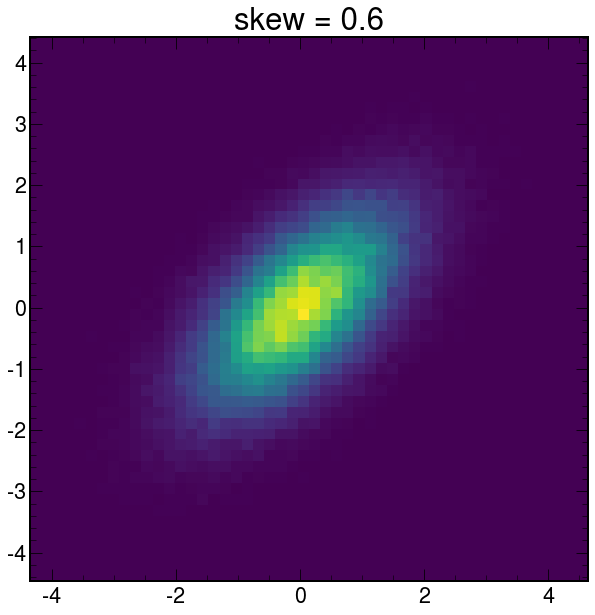

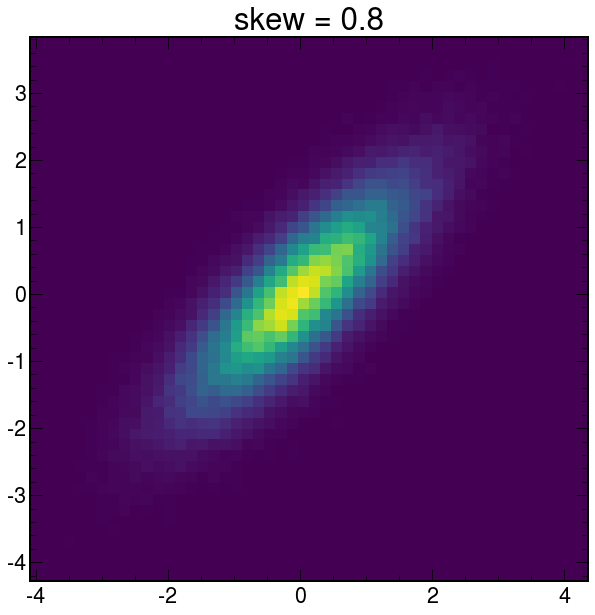

In [145]:
gauss1 = generate_gaussian(pos=[0, 0], n=100000, skew=0.6)
gauss2 = generate_gaussian(pos=[0, 0], n=100000, skew=0.8)
print(kstest(gauss1[:,0], gauss2[:,0])[0])

plt.hist2d(gauss1[:,0], gauss1[:,1], bins=50)
plt.title("skew = 0.6")
plt.show()

plt.hist2d(gauss2[:,0], gauss2[:,1], bins=50)
plt.title("skew = 0.8")
plt.show()

In [108]:
def skew_scan(metric, n, skews):
    metric_results = []
    base_gaussian = generate_gaussian(pos=[0,0], n=n, skew=0)
    for skew in skews:
        res = []
        for i in range(100):
            gaussian = generate_gaussian(pos=[0,0], n=n, skew=skew)
            res.append(metric(base_gaussian, gaussian))
        res_avg = np.mean(res)
        res_std = np.std(res, ddof=1)
        metric_results.append([skew, res_avg, res_std])
    return np.array(metric_results)
    
def shift_scan(metric, n, shifts):
    metric_results = []
    base_gaussian = generate_gaussian(pos=[0,0], n=n, skew=0)
    for shift in shifts:
        res = []
        for i in range(100):
            gaussian = generate_gaussian(pos=[shift,0], n=n, skew=0)
            res.append(metric(base_gaussian, gaussian))
        res_avg = np.mean(res)
        res_std = np.std(res, ddof=1)
        metric_results.append([shift, res_avg, res_std])
    return np.array(metric_results)

def full_scan(metrics, metric_labels, n, shifts, skews):
    colors = ["tab:blue", "tab:green", "tab:red", "tab:purple"]
    for metric, label, color in zip(metrics, metric_labels, colors):
        
        shift_results = shift_scan(metric, n, shifts)
        plt.errorbar(shift_results[:,0], shift_results[:,1], yerr = shift_results[:,2], capsize=5, marker="o", color=color)
        plt.xlabel("shift")
        plt.ylabel("distance")
        plt.title(f"{label}-Distance with {n} Points")
        plt.show()
        
        skew_results = skew_scan(metric, n, skews)
        plt.errorbar(skew_results[:,0], skew_results[:,1], yerr = skew_results[:,2], capsize=5, marker="o", color=color)
        plt.xlabel("skew")
        plt.ylabel("distance")
        plt.title(f"{label}-Distance with {n} Points")
        plt.show()        

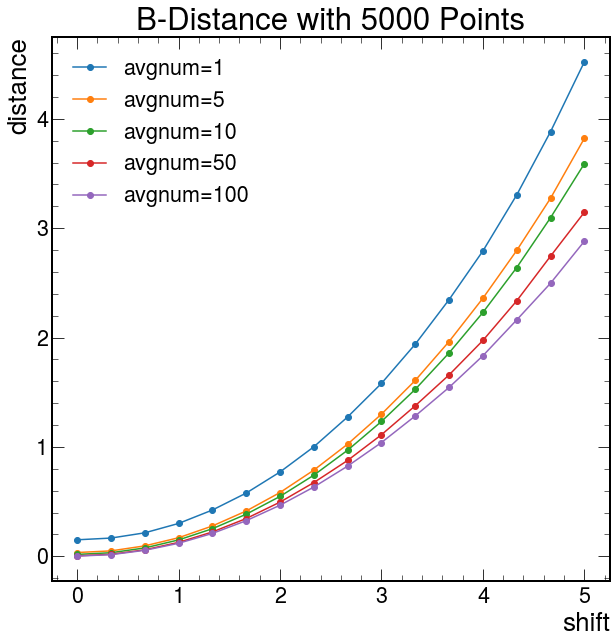

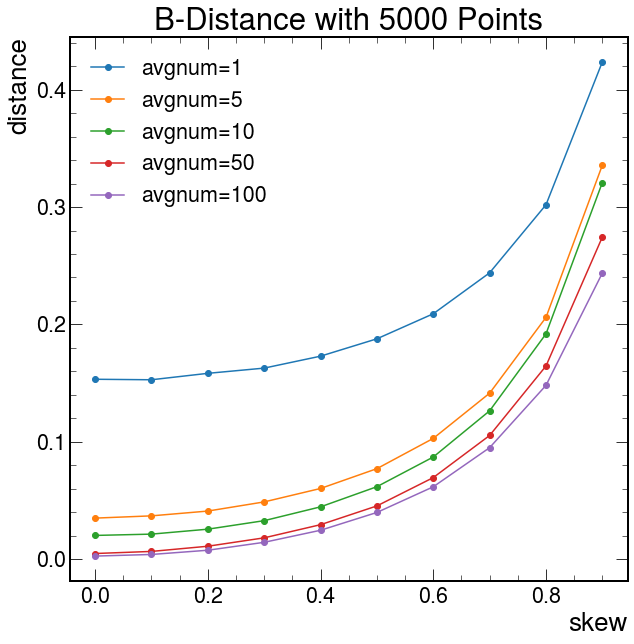

In [136]:
def B_distance_varybins(a1, a2, avgnum):
    if len(a1) != len(a2): raise Exception("array dimensions don't match.")
    xmin, ymin = np.min(np.append(a1[:,0], a2[:,0])), np.min(np.append(a1[:,1], a2[:,1]))
    xmax, ymax = np.max(np.append(a1[:,0], a2[:,0])), np.max(np.append(a1[:,1], a2[:,1]))

    a1_distr = np.histogram2d(a1[:,0], a1[:,1], range=[[xmin, xmax], [ymin, ymax]], bins=int(np.sqrt(len(a1)/avgnum)))[0] / len(a1)
    a2_distr = np.histogram2d(a2[:,0], a2[:,1], range=[[xmin, xmax], [ymin, ymax]], bins=int(np.sqrt(len(a2)/avgnum)))[0] / len(a2)
    
    b_coeff = np.sum(np.sqrt(a1_distr*a2_distr))
    return -np.log(b_coeff)

shifts = np.linspace(0, 5, num=16)
skews = np.linspace(0, 0.9, num=10)

for avgnum in [1, 5, 10, 50, 100]:
    newB_distance = lambda a1, a2: B_distance_varybins(a1, a2, avgnum)
    shift_results = shift_scan(newB_distance, n, shifts)
    plt.plot(shift_results[:,0], shift_results[:,1], marker="o", label=f"avgnum={avgnum}")
plt.legend()
plt.xlabel("shift")
plt.ylabel("distance")
plt.title("B-Distance with 5000 Points")
plt.show()

for avgnum in [1, 5, 10, 50, 100]:
    newB_distance = lambda a1, a2: B_distance_varybins(a1, a2, avgnum)
    skew_results = skew_scan(newB_distance, n, skews)
    plt.plot(skew_results[:,0], skew_results[:,1], marker="o", label=f"avgnum={avgnum}")
plt.legend()
plt.xlabel("skew")
plt.ylabel("distance")
plt.title("B-Distance with 5000 Points")
plt.show()



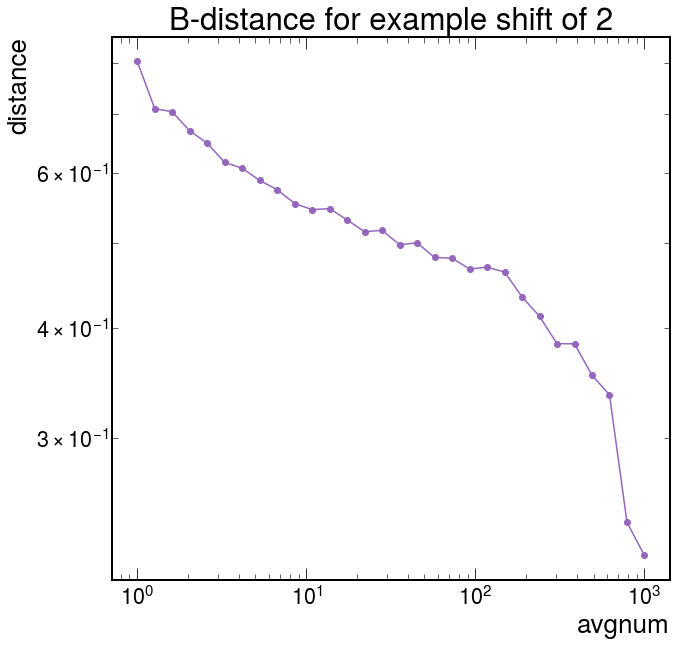

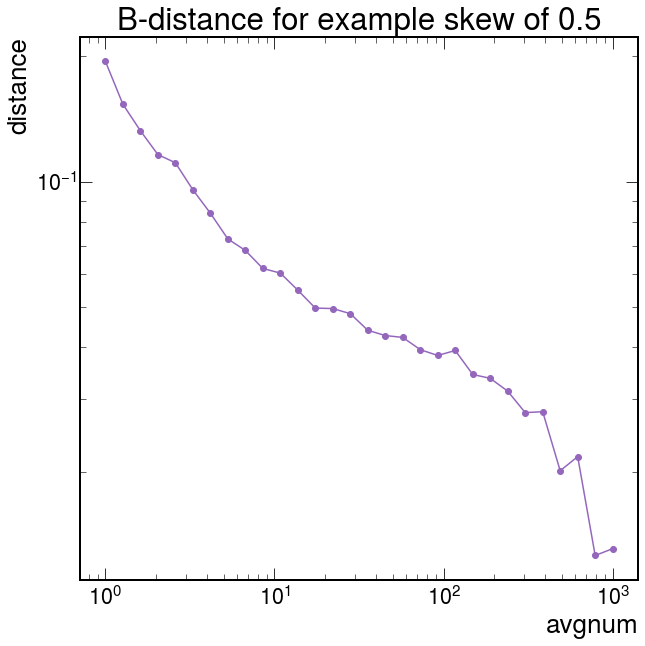

In [143]:

example_shift = [2]
example_skew = [0.5]

avgnums = np.logspace(0, 3, num=30)

distances = []
for avgnum in avgnums:
    newB_distance = lambda a1, a2: B_distance_varybins(a1, a2, avgnum)
    result = shift_scan(newB_distance, 10000, example_shift)
    distances.append(result[0,1])

plt.loglog(avgnums, distances, color="tab:purple", marker="o")
plt.xlabel("avgnum")
plt.ylabel("distance")
plt.title("B-distance for example shift of 2")
plt.show()

distances = []
for avgnum in avgnums:
    newB_distance = lambda a1, a2: B_distance_varybins(a1, a2, avgnum)
    result = skew_scan(newB_distance, 10000, example_skew)
    distances.append(result[0,1])

plt.loglog(avgnums, distances, color="tab:purple", marker="o")
plt.xlabel("avgnum")
plt.ylabel("distance")
plt.title("B-distance for example skew of 0.5")
plt.show()

KS
WS
B


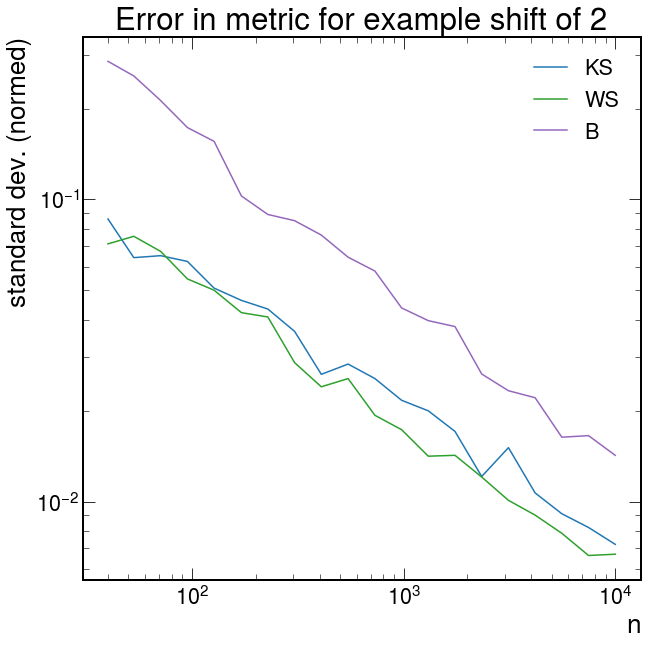

F
B


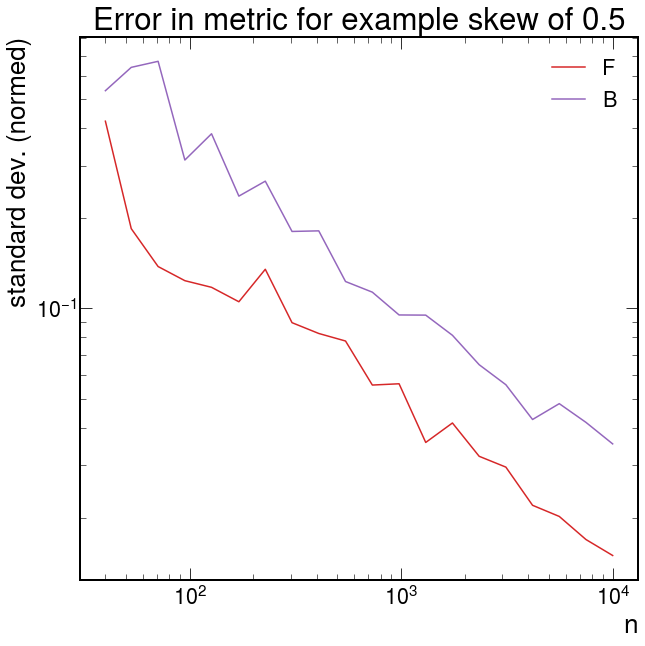

In [131]:
example_shift = [2]
example_skew = [0.5]

shift_metrics = [KS_distance, WS_distance, B_distance]
shift_metric_labels = ["KS", "WS", "B"]
shift_colors = ["tab:blue", "tab:green", "tab:purple"]

skew_metrics = [F_distance, B_distance]
skew_metric_labels = ["F", "B"]
skew_colors = ["tab:red", "tab:purple"]

nvals = np.logspace(np.log10(40), 4, num=20).astype(int)

for metric, label, color in zip(shift_metrics, shift_metric_labels, shift_colors):
    print(label)
    normed_std = []
    for n in nvals:
        metric_result = shift_scan(metric, n, example_shift)
        normed_std.append(metric_result[0, 2] / metric_result[0, 1])
    plt.loglog(nvals, normed_std, label=label, color=color)
plt.legend()
plt.xlabel("n")
plt.ylabel("standard dev. (normed)")
plt.title("Error in metric for example shift of 2")
plt.show()

for metric, label, color in zip(skew_metrics, skew_metric_labels, skew_colors):
    print(label)
    normed_std = []
    for n in nvals:
        metric_result = skew_scan(metric, n, example_skew)
        normed_std.append(metric_result[0, 2] / metric_result[0, 1])
    plt.loglog(nvals, normed_std, label=label, color=color)
plt.legend()
plt.xlabel("n")
plt.ylabel("standard dev. (normed)")
plt.title("Error in metric for example skew of 0.5")
plt.show()

[0.         0.33333333 0.66666667 1.         1.33333333 1.66666667
 2.         2.33333333 2.66666667 3.         3.33333333 3.66666667
 4.         4.33333333 4.66666667 5.        ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


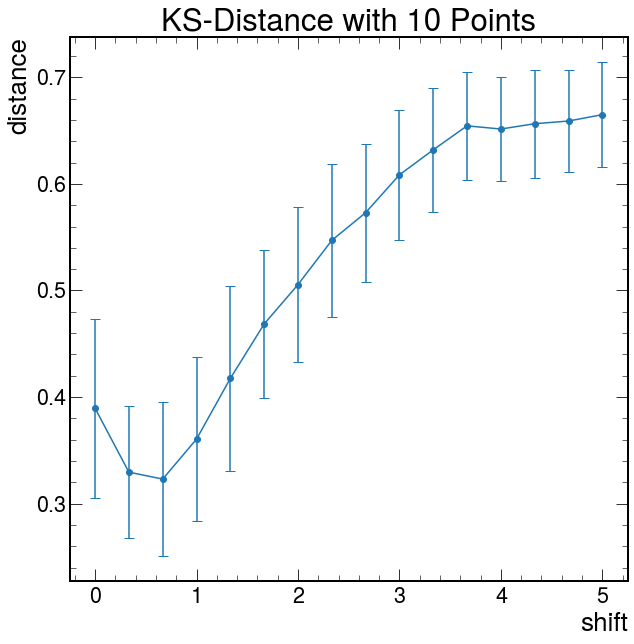

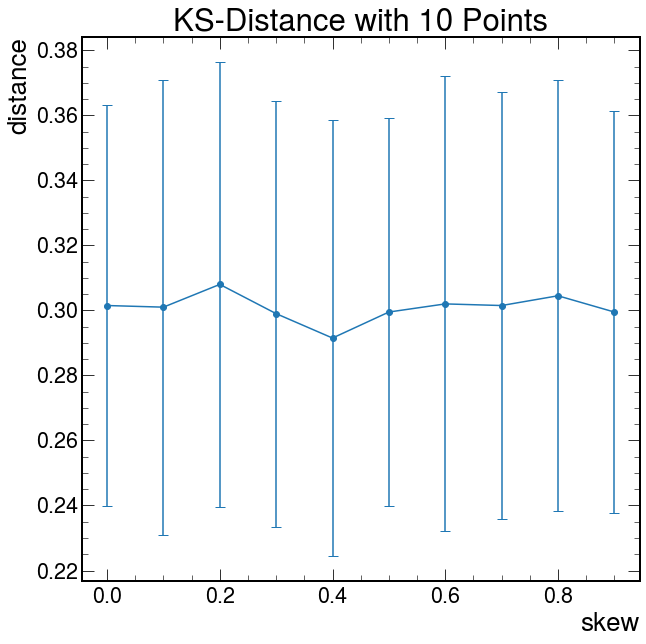

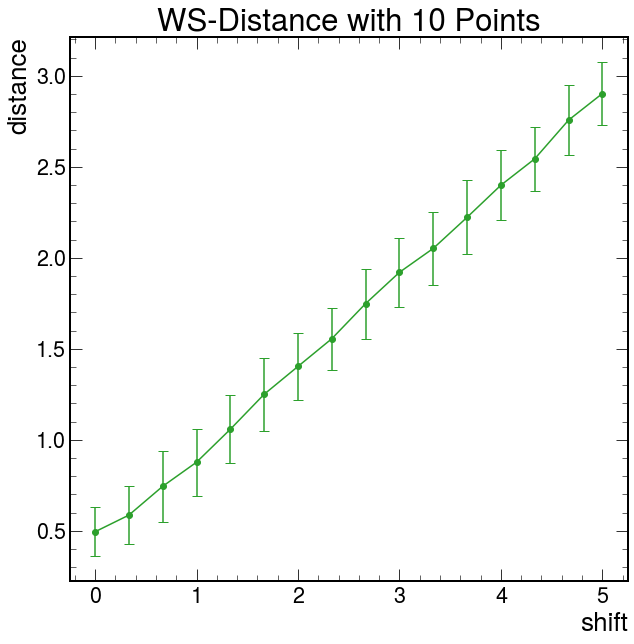

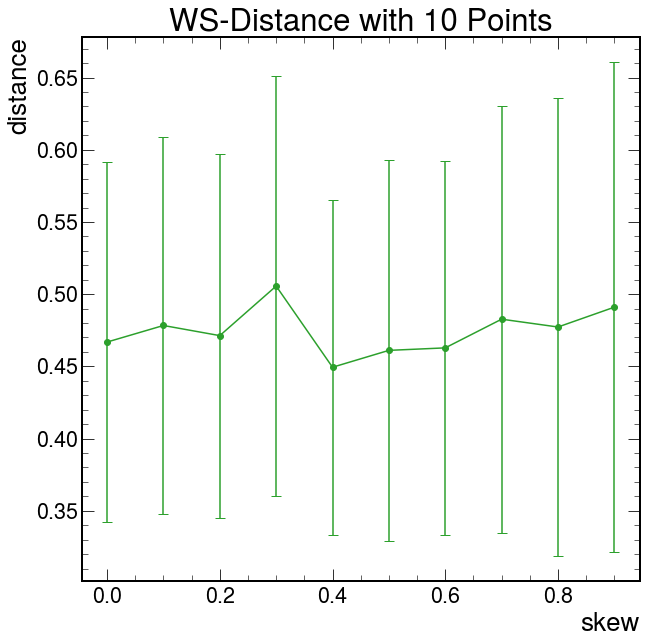

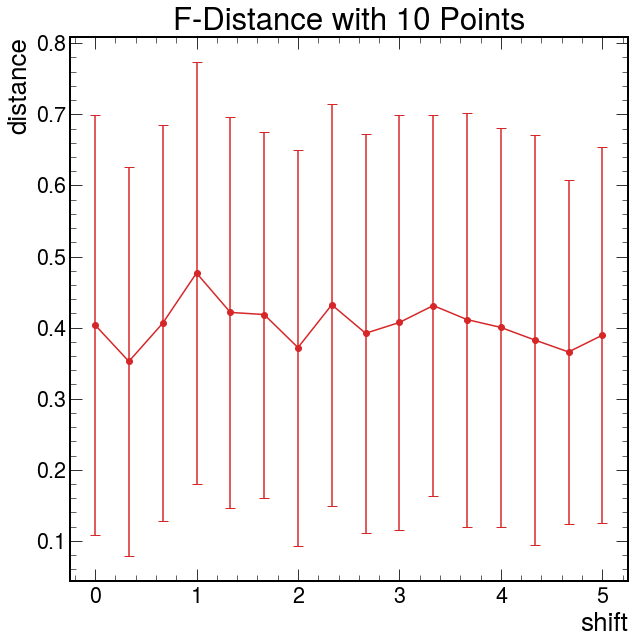

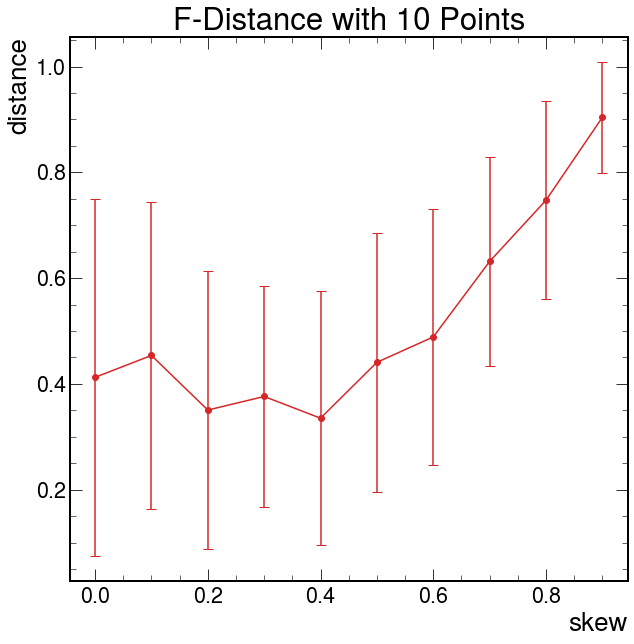

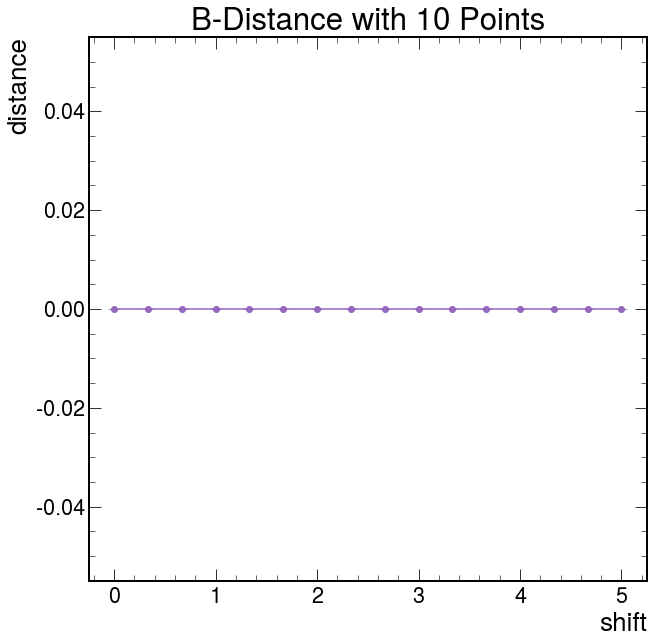

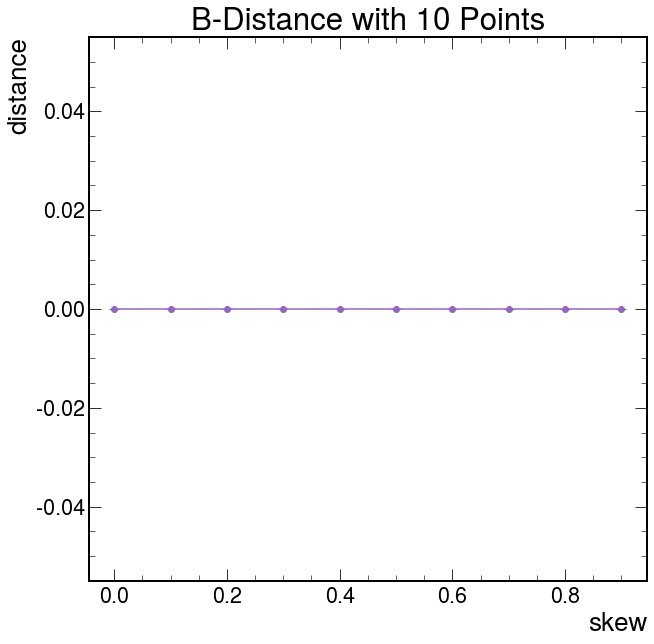

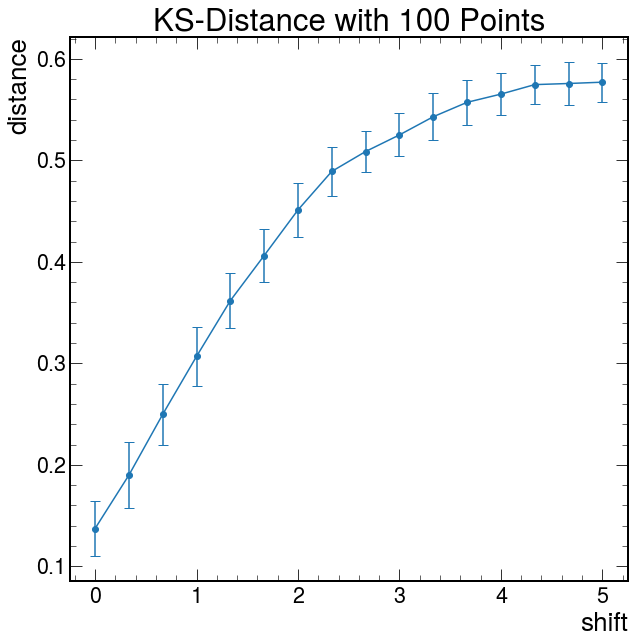

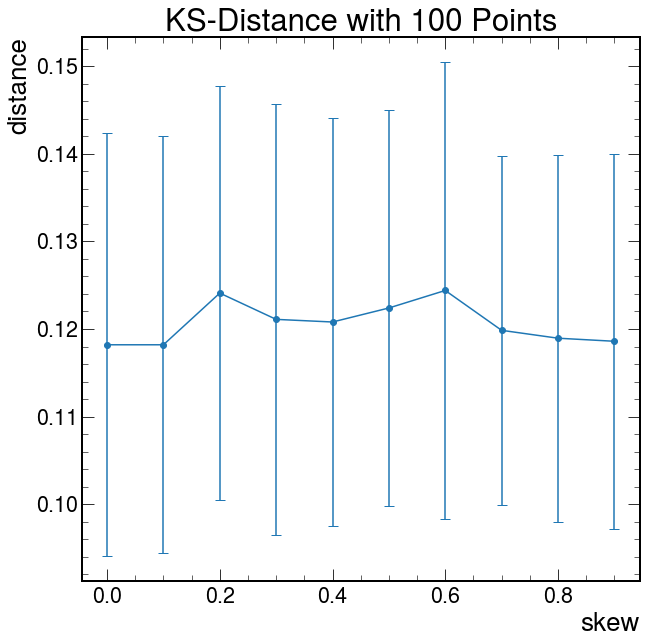

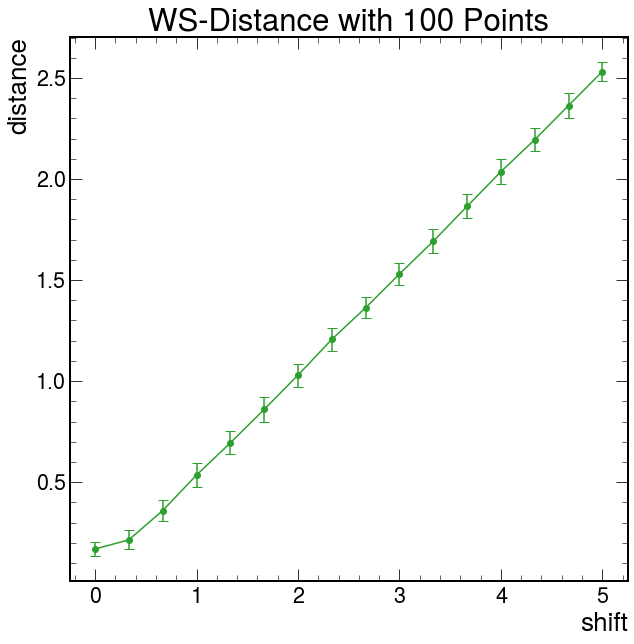

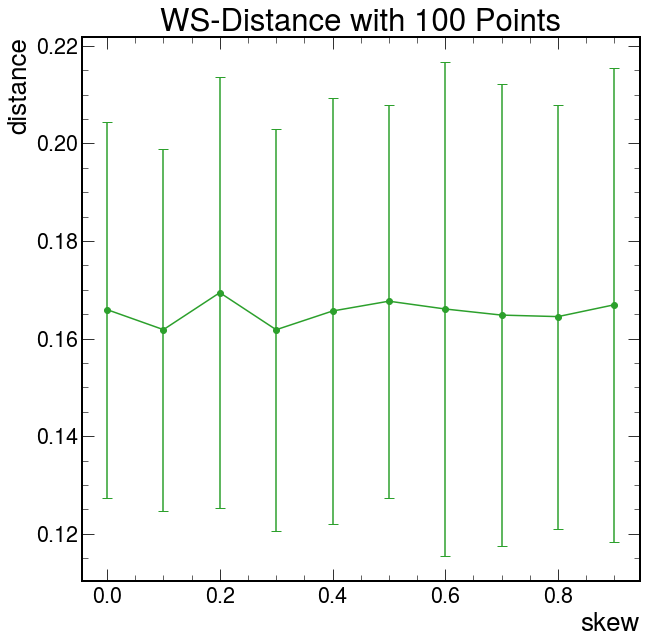

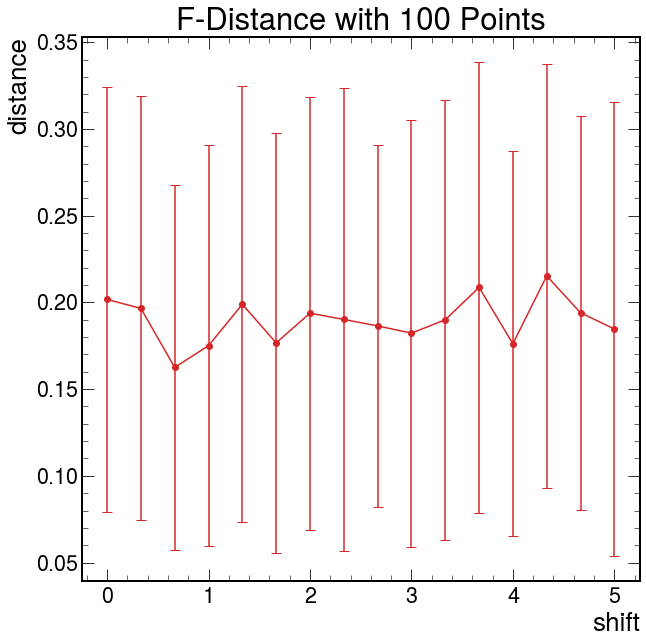

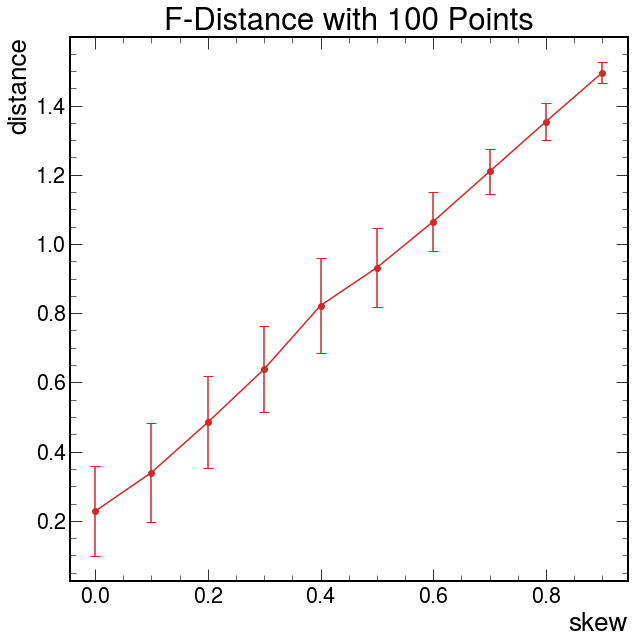

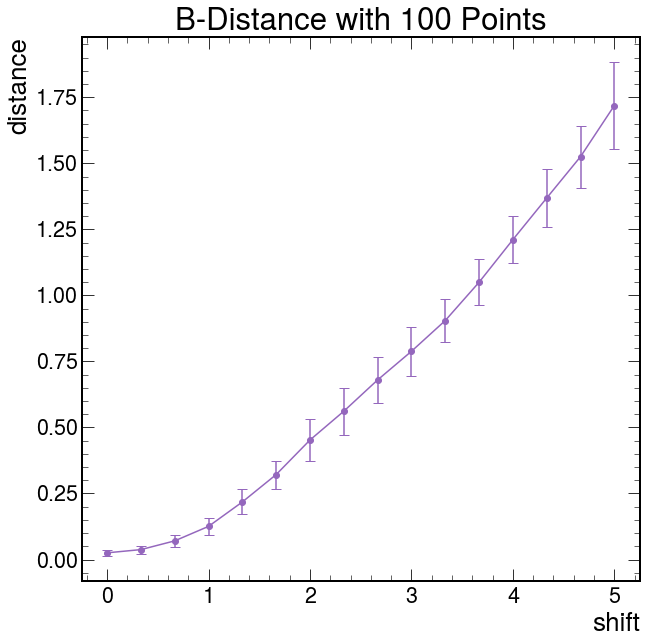

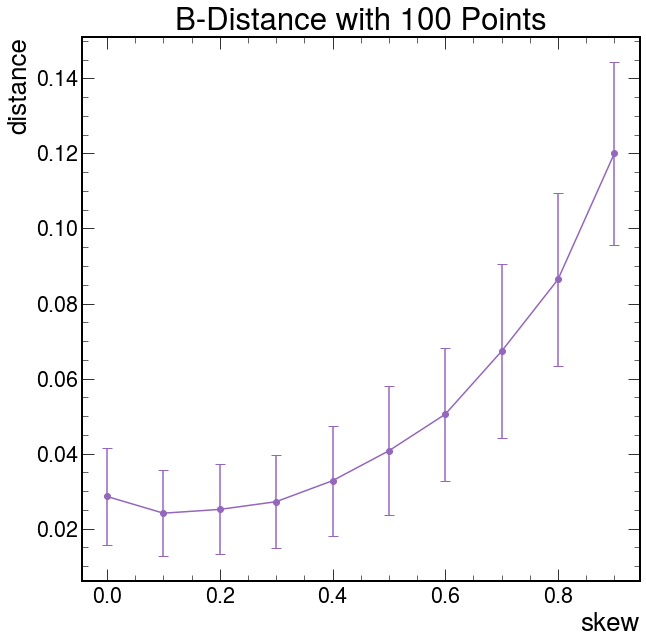

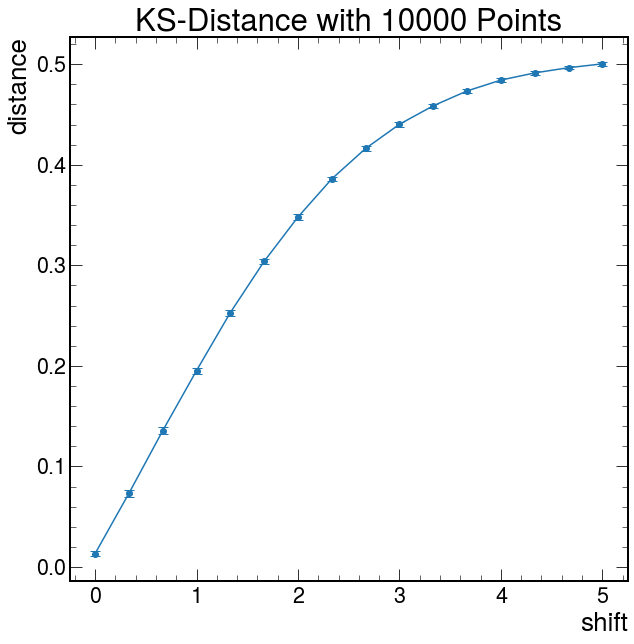

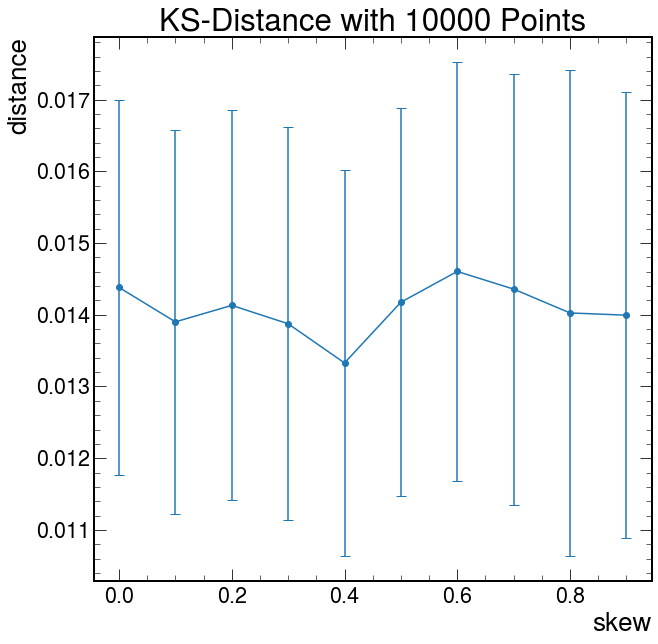

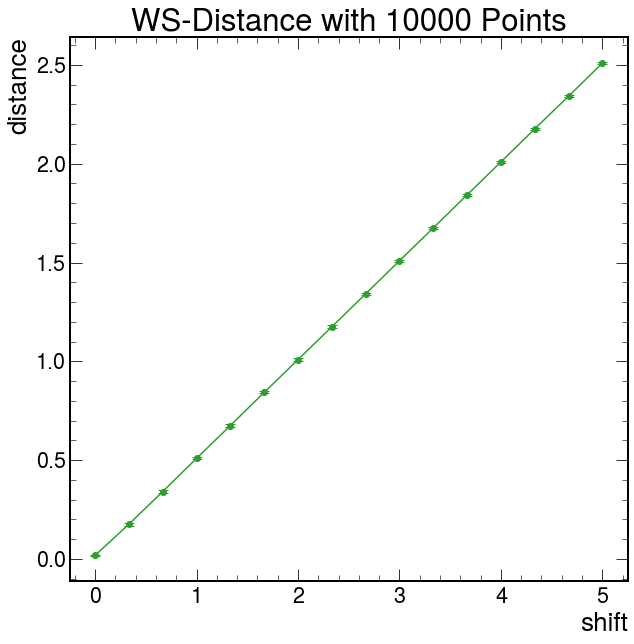

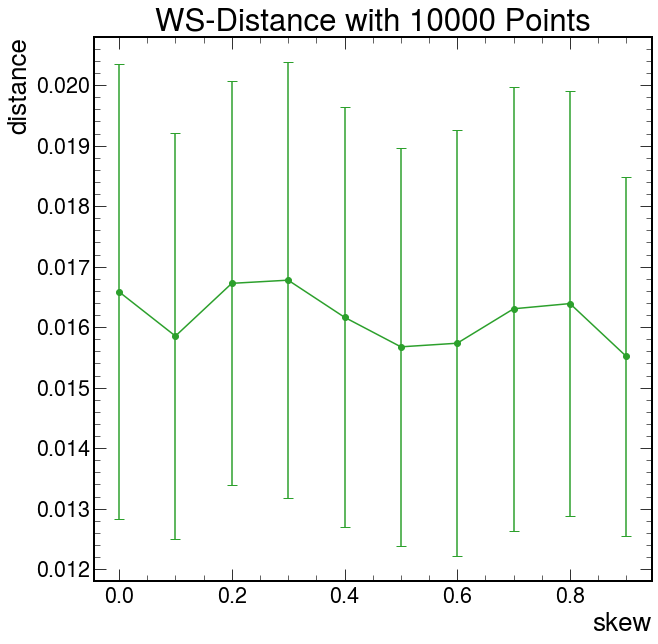

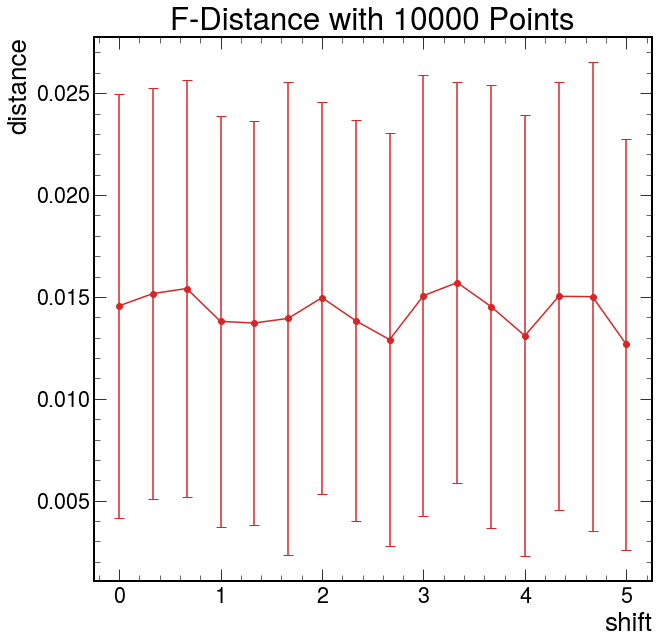

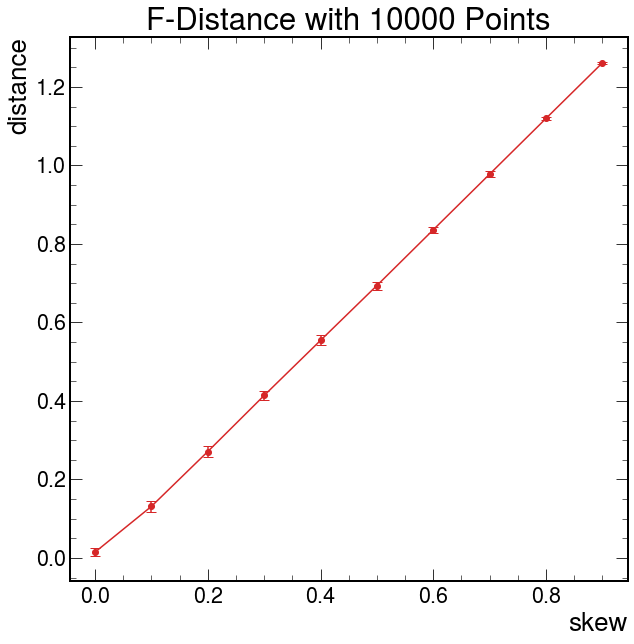

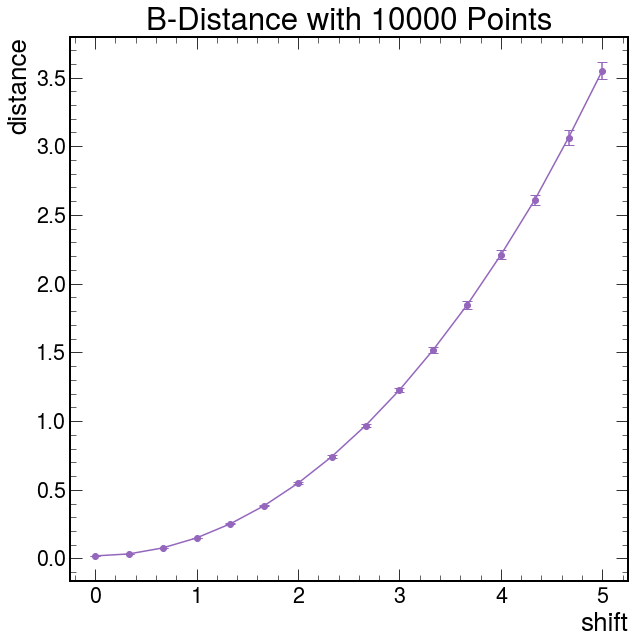

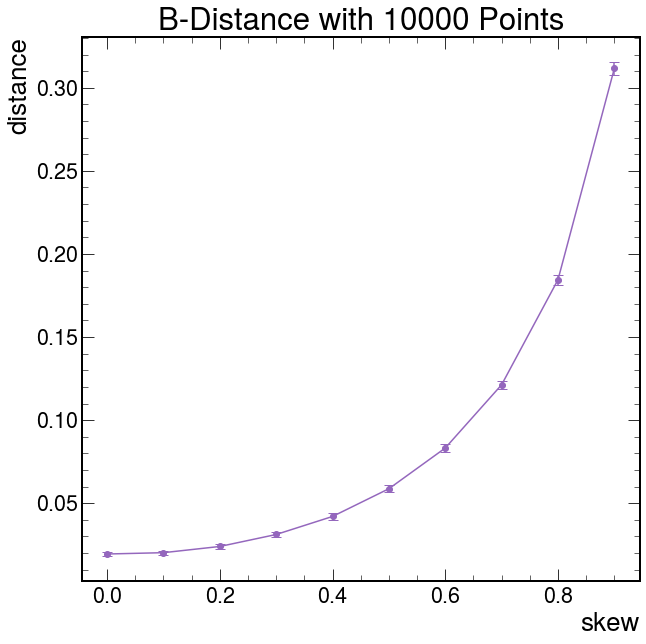

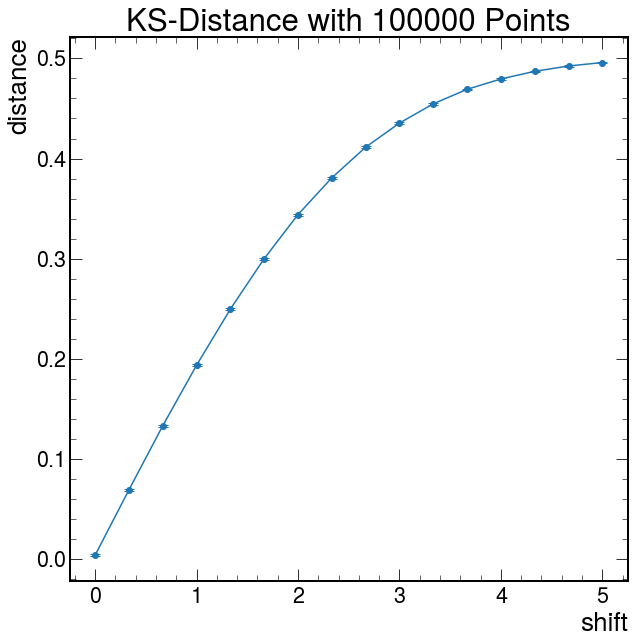

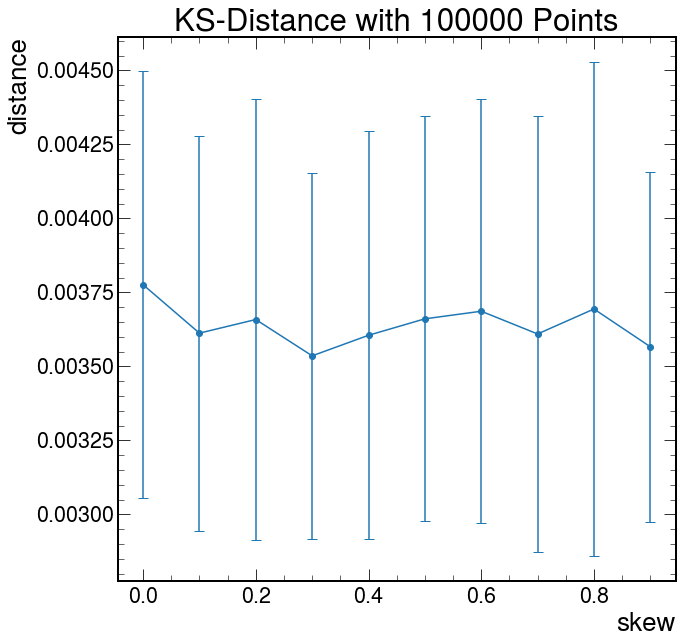

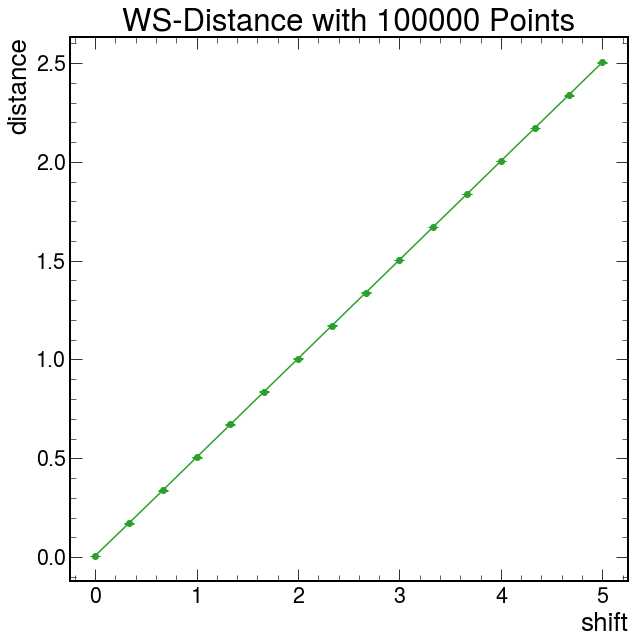

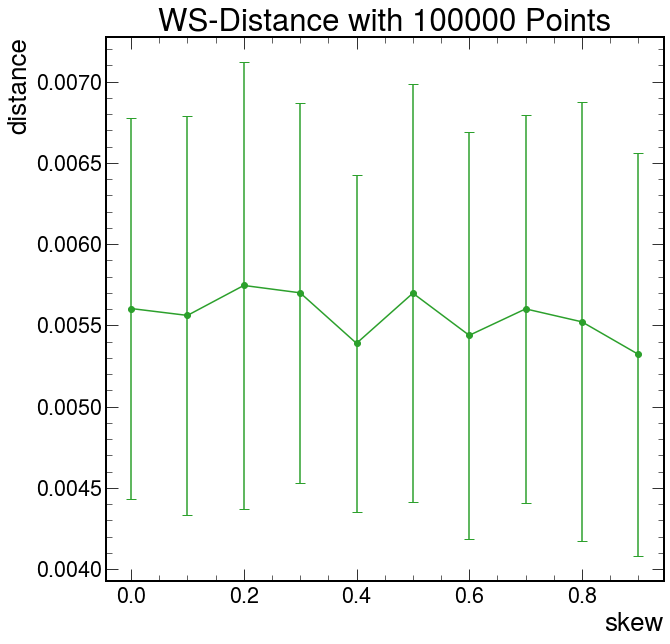

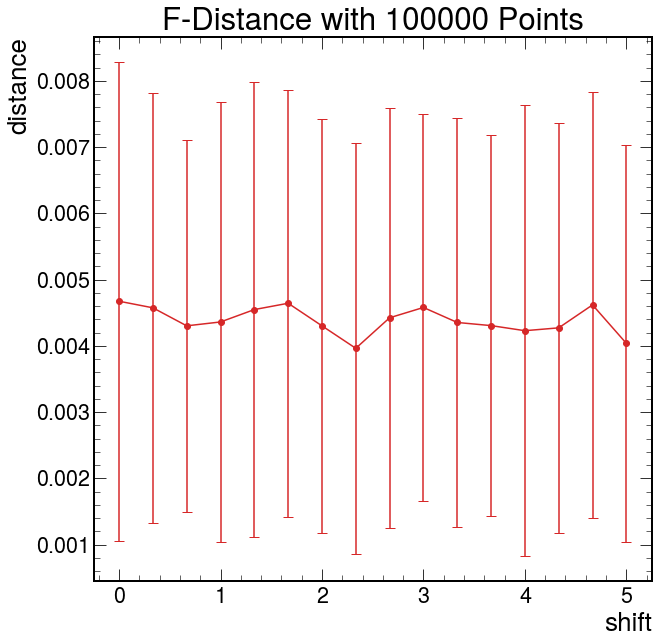

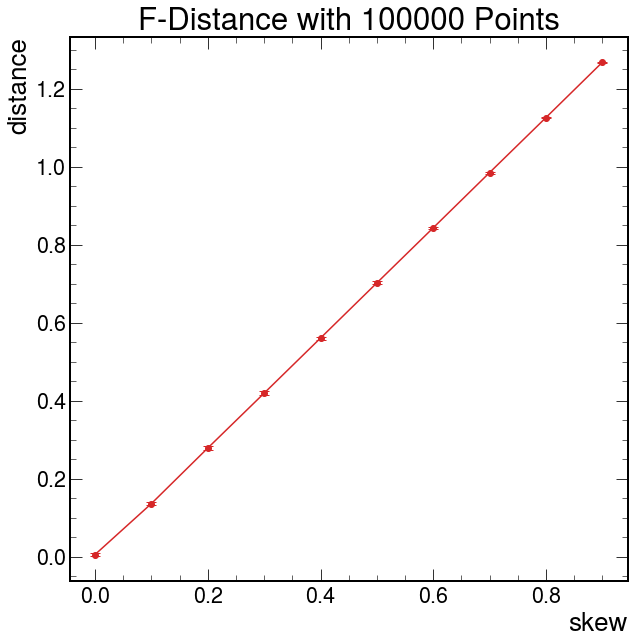

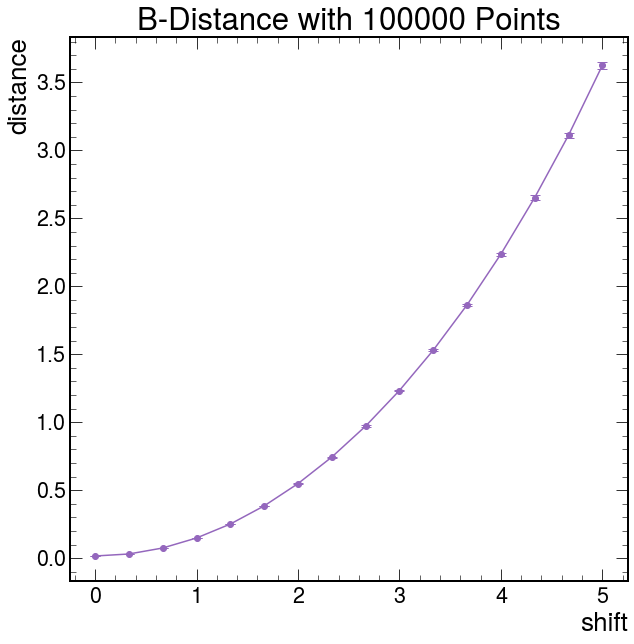

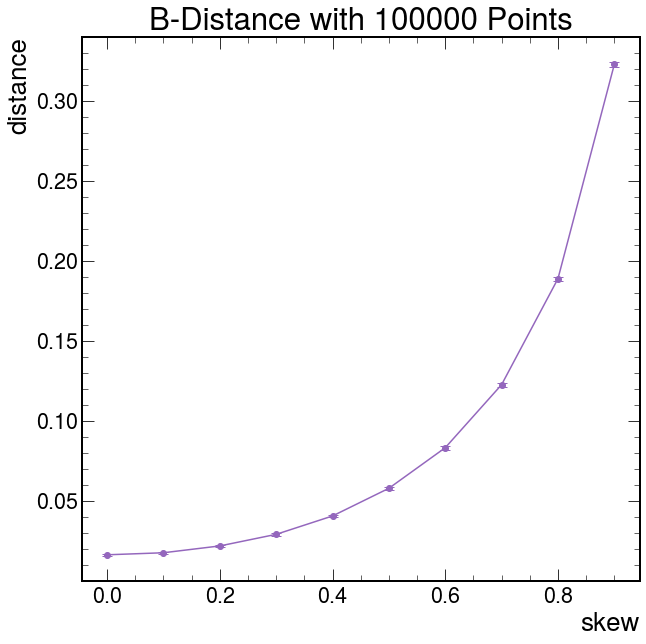

In [109]:
shifts = np.linspace(0, 5, num=16)
print(shifts)
skews = np.linspace(0, 0.9, num=10)
print(skews)

n = 1000

metrics = [KS_distance, WS_distance, F_distance, B_distance]
metric_labels = ["KS", "WS", "F", "B"]

for n in [10, 100, 1000, 10000, 100000]:
    full_scan(metrics, metric_labels, n, shifts, skews)



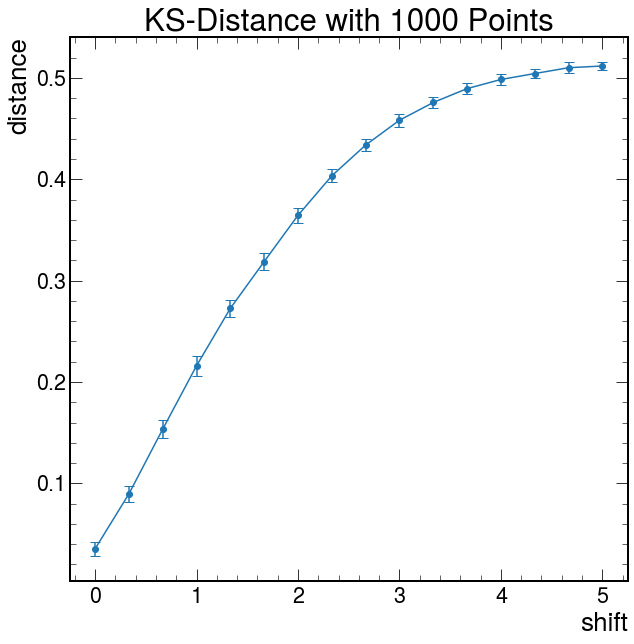

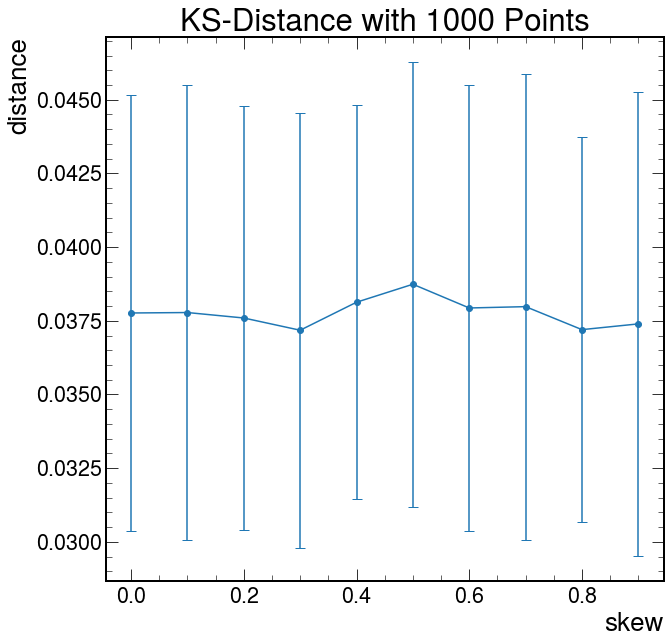

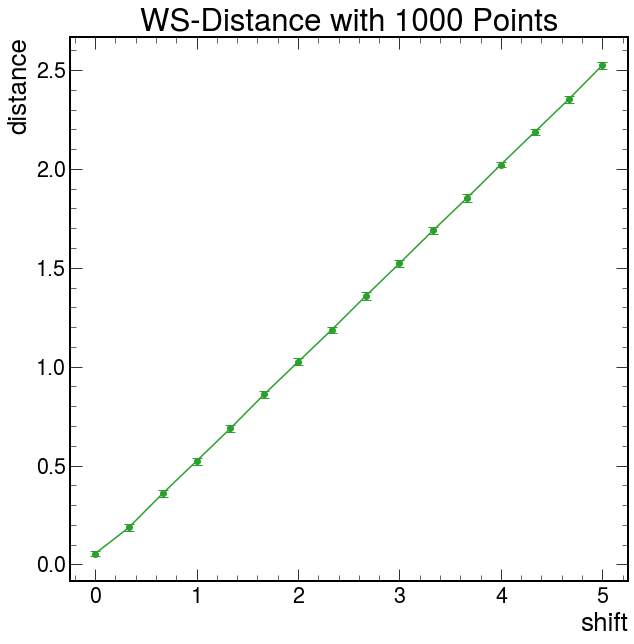

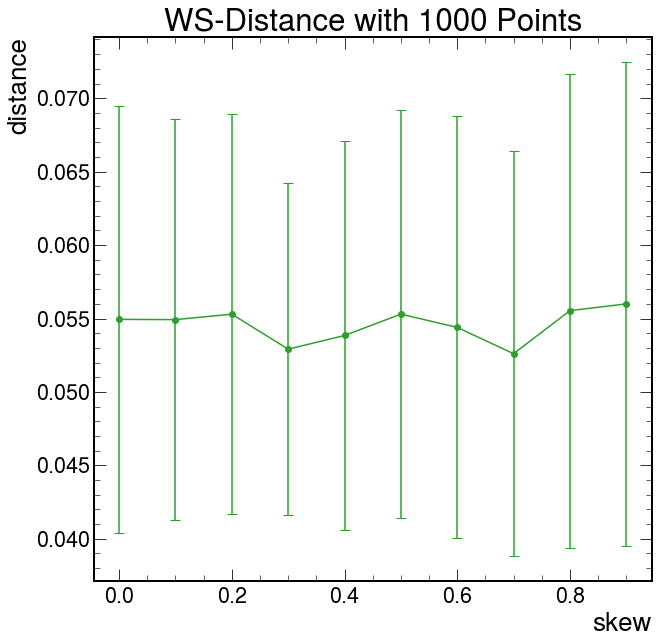

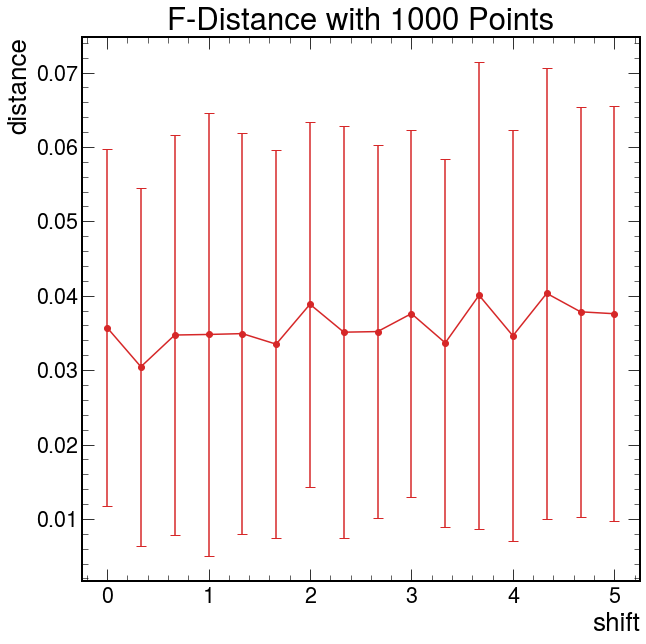

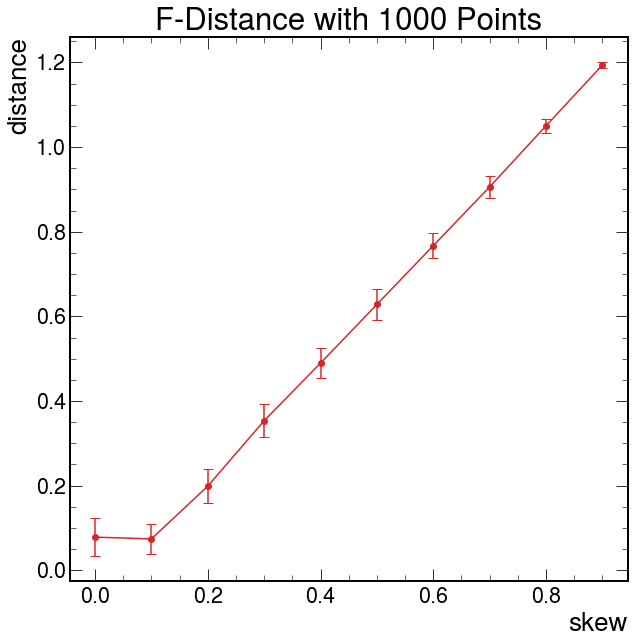

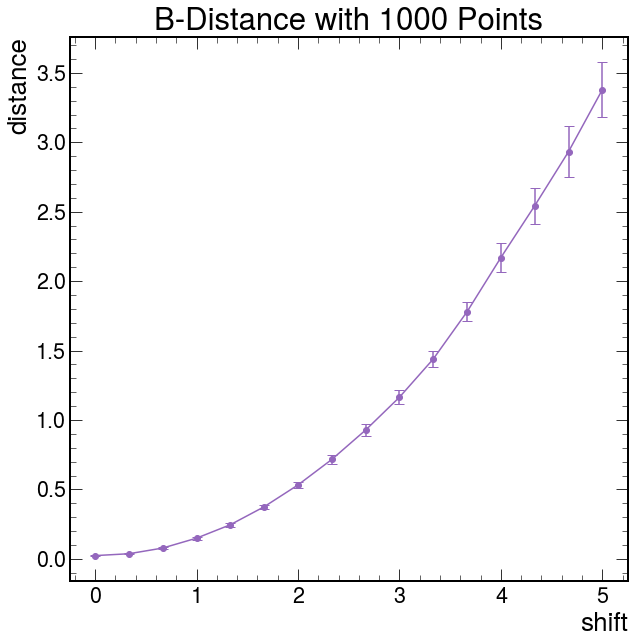

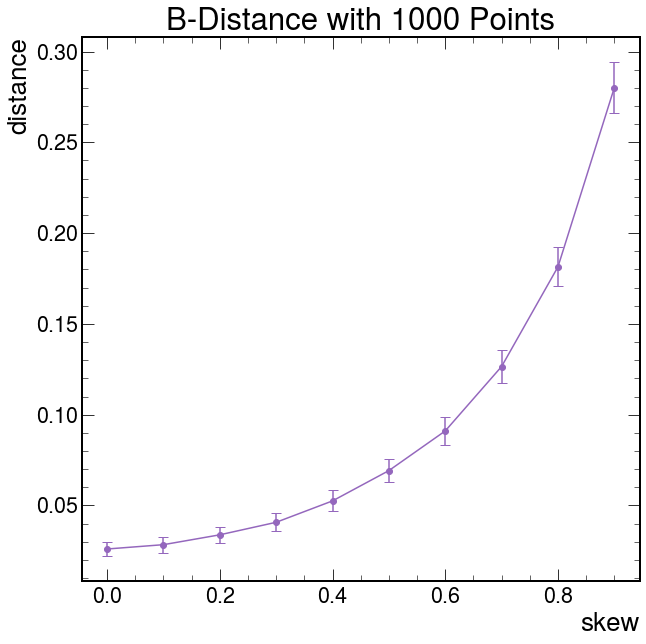

In [111]:
full_scan(metrics, metric_labels, 1000, shifts, skews)